In [99]:
import os
import geopandas as gp
import pandas as pd
import numpy as np
import shapely
import datetime
import io
import requests
import urllib.request

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from climata.usgs import DailyValueIO
from shapely.geometry import Point
from shapely.ops import cascaded_union


In [2]:
# First, make a merged shapefile of hucs of different orders from 1802, 1803, 1804

In [3]:
huc_order = "8"
huc_str = "WBDHU{}.shp".format(huc_order)

huc4s = ["1802", "1803", "1804"]
hu4_dirs = [os.path.join("../nhd", x, "Shape") for x in os.listdir("../nhd") if "." not in x]

In [4]:
def find_hucs(dir, huc_str):
    shp_files = [os.path.join(dir,x) for x in os.listdir(dir) if huc_str in x if "xml" not in x]
    return shp_files

gdfs = []

for i in hu4_dirs:
    gdfs.append(gp.read_file(find_hucs(i, huc_str)[0]))

hu4 = gp.GeoDataFrame(pd.concat(gdfs, ignore_index=True))


In [165]:
hu4 = gp.read_file("../shape/HU4_merged.shp")

# Read central valley shapefile
cv = gp.read_file("../shape/cv.shp")

# Load the crop mapping dwr data 
cm = gp.read_file("../shape/Crop__Mapping_2014.shp")

# Load cv shapefile
cvsa = gp.read_file("../shape/cv.shp")
crs = {"init":"epsg:4326"}
cvsa.crs = crs

# CA boundary
states = gp.read_file("../shape/states.shp")
ca = states[states['STATE_NAME'] == "California"]

# load canals shapefile 
canals = gp.read_file("../shape/Canals_and_Aqueducts_local.shp")
canals = gp.sjoin(canals, ca, op = "intersects")

swp = gp.read_file("../shape/SWP_Canals.shp")
swp = gp.sjoin(swp, ca, op = "intersects")

# Read stream reaches from c2vsim shapefile 
reaches = gp.read_file("../c2vsim/C2VSimFG_StreamReaches.shp").dropna()
reaches = reaches.to_crs({'init': 'epsg:4326'})

# read rivers
rivers = gp.read_file("../shape/rivers_CVW.shp")

# irrigated
irrigated = gp.read_file("../shape/irrigated.shp")
non_irrigated = gp.read_file("../shape/non_irrigated.shp")

# SSJT
s = gp.read_file("../Shape/1802_4.shp")
sj = gp.read_file("../Shape/1804_4.shp")
t = gp.read_file("../Shape/1803_4.shp")

# grace footprint
grace = gp.read_file("../shape/argus_grace.shp")

wells = gp.read_file("../shape/casgem_wells.shp")

# Sierra side (eastern) huc8s from south to north: 

'''

sierra_hu8s = ["18030003", "18030004", "18030005", "18030006", "18030007", # 1803 Tulare
               "18030012", "18030009", "18040001", "18040007", "18040008", 
               
               "18040010", "18040011", "18040012", "18040013", "18040014", # 1804 San Joaquin 
               "18040010", "18040011", "18040012", "18040013", "18040014",
               "18040009", 
               
               "18020111", "18020161", "18020126", "18020125", "18020159", # 1802 Sac
               "18020158", "18020157", "18020155", "18020154", "18020151",
               "18020153", "18020156"]
               
'''

/anaconda3/envs/gis/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


'\n\nsierra_hu8s = ["18030003", "18030004", "18030005", "18030006", "18030007", # 1803 Tulare\n               "18030012", "18030009", "18040001", "18040007", "18040008", \n               \n               "18040010", "18040011", "18040012", "18040013", "18040014", # 1804 San Joaquin \n               "18040010", "18040011", "18040012", "18040013", "18040014",\n               "18040009", \n               \n               "18020111", "18020161", "18020126", "18020125", "18020159", # 1802 Sac\n               "18020158", "18020157", "18020155", "18020154", "18020151",\n               "18020153", "18020156"]\n               \n'

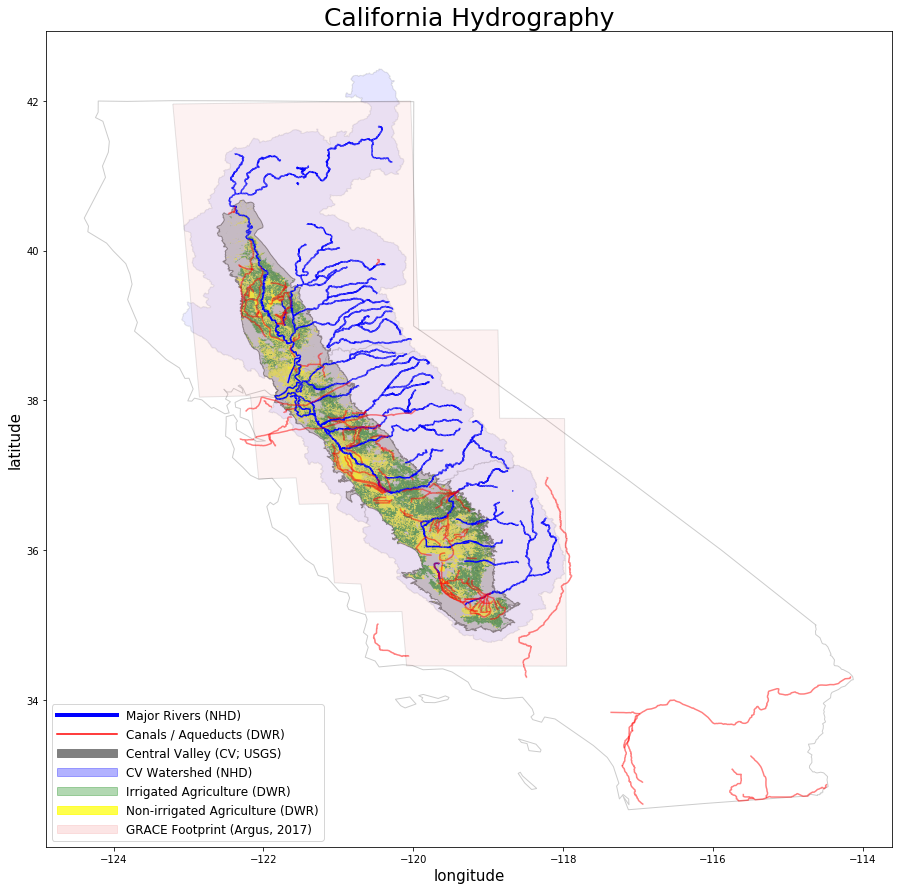

In [55]:
fig, ax = plt.subplots(figsize = (20, 15))

# Plot the huc4s
s.plot(ax = ax, color = 'blue', alpha = 0.1, edgecolor = "black")
sj.plot(ax = ax, color = 'blue', alpha = 0.1, edgecolor = "black")
t.plot(ax = ax, color = 'blue', alpha = 0.1,  edgecolor = "black")

# Rivers, CV, canals, CA, irrigated, non irrigated
rivers.plot(ax = ax, color = "blue", label = "major rivers")
cv.plot(ax = ax, color = "gray", edgecolor = "black", alpha = 0.5, label = "central valley")
canals.plot(ax = ax, color = "red", edgecolor = "none", alpha = 0.5, label = "CVP canals / aqueducts")
swp.plot(ax = ax, color = "red", edgecolor = "none", alpha = 0.5, label = "SWP canals / aqueducts")
ca.plot(ax = ax, color = "white", edgecolor = "black", alpha = 0.2)
irrigated.plot(ax = ax, color = "green", alpha = 0.7, label = "irrigated")
non_irrigated.plot(ax = ax, color = "yellow", alpha = 0.7, label = 'non-irrigated')
grace.plot(ax = ax, color = "lightcoral", alpha = 0.1, edgecolor = 'black')

plt.ylabel('latitude', size = 15)
plt.xlabel('longitude', size = 15)

legend_elements = [Line2D([0], [0], color='b', lw=4, label='Major Rivers (NHD)'),
                   Line2D([0], [0], color='red', label = "Canals / Aqueducts (DWR)" ),
                   Patch(facecolor='gray', edgecolor='gray',label='Central Valley (CV; USGS)'), 
                   Patch(facecolor='blue', alpha = 0.3, edgecolor='blue',label='CV Watershed (NHD)'),
                   Patch(facecolor='green', alpha = 0.3, edgecolor='green',label='Irrigated Agriculture (DWR)'),
                   Patch(facecolor='yellow', alpha = 0.7, edgecolor='yellow',label='Non-irrigated Agriculture (DWR)'),
                   Patch(facecolor='lightcoral', alpha = 0.2, edgecolor='lightcoral',label='GRACE Footprint (Argus, 2017)')
                  ]

plt.legend(loc = "lower left", handles = legend_elements, prop={'size':12},handlelength=5)

plt.title("California Hydrography", size = 25)

plt.show()

In [56]:
def get_streamflow(huc8):
    
    '''
    call climata API supplying huc8 argument to get each gaging station within each basin 
    '''
    
    data =  DailyValueIO (
            start_date="2001-01-01", 
            end_date="2018-01-01",
            basin=huc8,
            parameter="00060",
            )
    
    qs = []
    ds = []
    lats = []
    lons = []
    ids = []

    for series in data:
        values = []
        dates = []
        lats.append(series.latitude)
        lons.append(series.longitude)
        ids.append(series.site_code)

        for row in series.data:
            values.append(row.value)
            dates.append(row.date)

        qs.append(values)
        ds.append(dates)
    
    geometry = [Point(xy) for xy in zip(lons, lats)]
    df = pd.DataFrame(geometry)
    crs = {'init': 'epsg:4326'}
    gdf = gp.GeoDataFrame(df, crs=crs, geometry=geometry)
    
    return gdf, qs, ds, ids

In [57]:
# Go into the nhd dataset and grab the hu8s 

huc_order = "8"
huc_str = "WBDHU{}.shp".format(huc_order)

huc4s = ["1802", "1803", "1804"]
hu4_dirs = [os.path.join("../nhd", x, "Shape") for x in os.listdir("../nhd") if "." not in x]

def find_hucs(dir, huc_str):
    shp_files = [os.path.join(dir,x) for x in os.listdir(dir) if huc_str in x if "xml" not in x]
    return shp_files

gdfs = []

for i in hu4_dirs:
    gdfs.append(gp.read_file(find_hucs(i, huc_str)[0]))

hu4 = gp.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

In [58]:

gdfs = []
qs = []
ds = []
ids = []

for i in hu4['HUC8']:
    print (i)
    gdf, q, d, i = get_streamflow(i)
    gdfs.append(gdf)
    qs.append(q)
    ds.append(d)
    ids.append(i)


18020002
18020003
18020004
18020005
18020104
18020111
18020115
18020116
18020121
18020122
18020123
18020125
18020126
18020128
18020129
18020151
18020152
18020153
18020154
18020155
18020156
18020157
18020158
18020159
18020161
18020162
18020163
18020001
18040001
18040002
18040003
18040006
18040007
18040008
18040009
18040010
18040011
18040012
18040013
18040014
18040051
18030001
18030002
18030003
18030004
18030005
18030006
18030007
18030009
18030010
18030012


In [59]:
# Un-nest the lists

q_f = np.array([item for sublist in qs for item in sublist])
d_f = np.array([item for sublist in ds for item in sublist])
ids_f = [item for sublist in ids for item in sublist]

In [76]:
# Make a gdf of the stations and join the lists of q, ID and dates

stations_gdf = gp.GeoDataFrame(pd.concat(gdfs, ignore_index=True, sort = False))
stations_gdf['Q'] = q_f
stations_gdf['ID'] = ids_f
stations_gdf['dates'] = d_f

# Compute the daily mean discharges and join to gdf
means = []
for i, x in enumerate(q_f): 
    means.append(np.mean(x))
    
stations_gdf['mean'] = means

# Extract some statistics for plotting
max_val = stations_gdf['mean'].max()
med_val = stations_gdf['mean'].median()
min_val = stations_gdf['mean'].min()

# Get stations corresponding to those vals
s1 = stations_gdf[stations_gdf['mean'] == max_val]
s2 = stations_gdf[stations_gdf['mean'] == med_val]
s3 = stations_gdf[stations_gdf['mean'] == min_val]

# Calc a few percentiles in the data 
p1 = np.percentile(stations_gdf['mean'],50)
p2 = np.percentile(stations_gdf['mean'],75)
p3 = np.percentile(stations_gdf['mean'],90)
p4 = np.percentile(stations_gdf['mean'],99)

In [77]:
# Inflows from xiao et al + ones I added in last row 
stations = [11446500, 11376550, 11423800, 11384000, 11390000 ,11451760,
            11372000, 11335000, 11376000, 11374000, 11383500, 11329500,
            11211300, 11424500, 11379500, 11407150, 11257500, 11209900,
            11192950, 11251600, 11225000, 11270900, 11381500, 11221700,
            11325500, 11384350, 11454000, 11370500, 11251000, 11302000, 
            11388000, 11382000, 11289650, 11199500, 11421000, 
           
            11208818, 11204100, 11200800, 11218400, 11289000, 11323500
           ]

# The CA Aqueduct takes water out of the CV: 
stations_out = ["11109396"]

stations = [str(x) for x in stations]

inflow = stations_gdf[stations_gdf['ID'].isin(stations)]
outflow = stations_gdf[stations_gdf.ID == "11109396"]


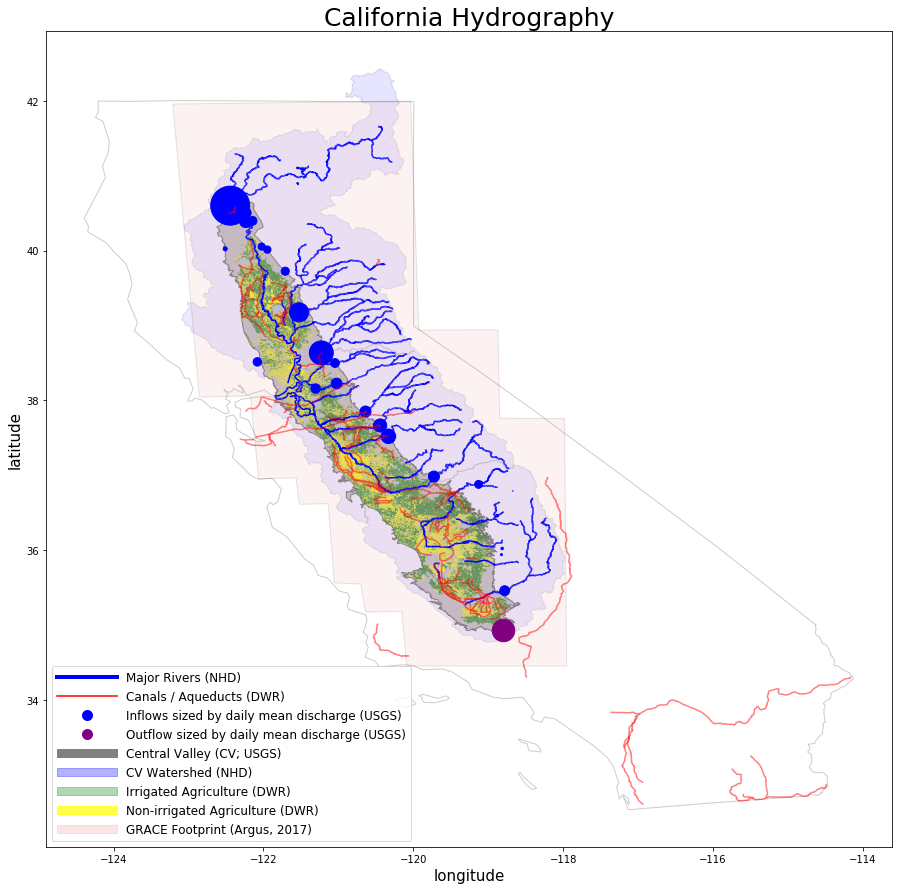

In [203]:
fig, ax = plt.subplots(figsize = (20, 15))

# Plot the huc4s
s.plot(ax = ax, color = 'blue', alpha = 0.1, edgecolor = "black")
sj.plot(ax = ax, color = 'blue', alpha = 0.1, edgecolor = "black")
t.plot(ax = ax, color = 'blue', alpha = 0.1,  edgecolor = "black")

# Rivers, CV, canals, CA, irrigated, non irrigated
rivers.plot(ax = ax, color = "blue", label = "major rivers")
cv.plot(ax = ax, color = "gray", edgecolor = "black", alpha = 0.5, label = "central valley")
canals.plot(ax = ax, color = "red", edgecolor = "none", alpha = 0.5, label = "CVP canals / aqueducts")
swp.plot(ax = ax, color = "red", edgecolor = "none", alpha = 0.5, label = "SWP canals / aqueducts")
ca.plot(ax = ax, color = "white", edgecolor = "black", alpha = 0.2)
irrigated.plot(ax = ax, color = "green", alpha = 0.7, label = "irrigated")
non_irrigated.plot(ax = ax, color = "yellow", alpha = 0.7, label = 'non-irrigated')
grace.plot(ax = ax, color = "lightcoral", alpha = 0.1, edgecolor = 'black')
inflow.plot(ax=ax, marker=".", alpha=1, c = "blue", markersize = inflow['mean']*0.7, label = "USGS gauge Inflow sized by $Q_{daily}$ ")
outflow.plot(ax=ax, marker=".", alpha=1, c = "purple", markersize = outflow['mean'], label = "CA Aquedut Outflow sized by $Q_{daily}$ ")

plt.ylabel('latitude', size = 15)
plt.xlabel('longitude', size = 15)

legend_elements = [Line2D([0], [0], color='b', lw=4, label='Major Rivers (NHD)'),
                   Line2D([0], [0], color='red', label = "Canals / Aqueducts (DWR)" ),
                   Line2D([0], [0], color="blue",linestyle = "none", marker='o',markersize=10, label = "Inflows sized by daily mean discharge (USGS)"),
                   Line2D([0], [0], color="purple", linestyle = "none", marker='o',markersize=10, label = "Outflow sized by daily mean discharge (USGS)"),
                   Patch(facecolor='gray', edgecolor='gray',label='Central Valley (CV; USGS)'), 
                   Patch(facecolor='blue', alpha = 0.3, edgecolor='blue',label='CV Watershed (NHD)'),
                   Patch(facecolor='green', alpha = 0.3, edgecolor='green',label='Irrigated Agriculture (DWR)'),
                   Patch(facecolor='yellow', alpha = 0.7, edgecolor='yellow',label='Non-irrigated Agriculture (DWR)'),
                   Patch(facecolor='lightcoral', alpha = 0.2, edgecolor='lightcoral',label='GRACE Footprint (Argus, 2017)')
                  ]

plt.legend(loc = "lower left", handles = legend_elements, prop={'size':12},handlelength=5)

plt.title("California Hydrography", size = 25)

plt.show()

In [82]:
# Write the inflow to file 

# Make a df of everything

in_dfs = []

for idx, x in enumerate(q_f):
    sdf1 = pd.DataFrame(q_f[idx], d_f[idx], columns = [ids_f[idx]])
    in_dfs.append(sdf1)

In [88]:
# Filter for the stations of interest
fin = pd.concat(in_dfs, axis = 1)

fin_in = fin.loc[:, fin.columns.str.contains('|'.join(stations))]

# calc the daily sums in
fin_in['sum_cfs'] = fin_in.sum(axis = 1)

# Calc the monthly sums
sum_df = pd.DataFrame(fin_in['sum_cfs'].resample('M').sum())

# Convert cfs to km3 / mon
sum_df['sum_km3'] = sum_df.sum_cfs * 0.0283168 * 1e-9 * 86400

/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Text(0, 0.5, '$km^3$')

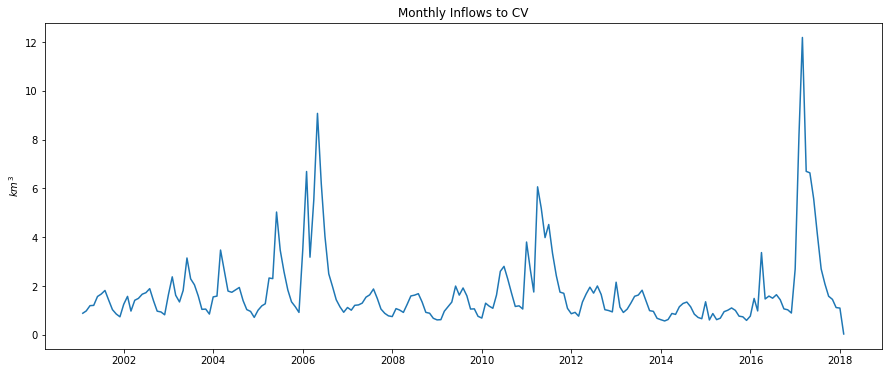

In [89]:
plt.figure(figsize=(15,6))
plt.title("Monthly Inflows to CV")
plt.plot(sum_df.sum_km3)
plt.ylabel("$km^3$")


In [ ]:
# sum_df.to_csv("../data/Q_s_into_CV.csv")

In [90]:
reservoirs = gp.read_file("../shape/cdec_reservoirs.shp")

In [117]:
within_cv = gp.sjoin(reservoirs, cv, how='inner', op='within')
within_ssjt = gp.sjoin(reservoirs, hu4, how='inner', op='within')

In [160]:
# Download Storage (SensorNums = 15) data by query str:

start = datetime.datetime(2001, 1, 1)
end = datetime.datetime(2019, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

ssjt_data = {}

for i in within_ssjt.ID:
    print("processing " + i )
    url = "https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums=15&dur_code=M&Start=2001-01-01&End=2018-12-01".format(i)
    urlData = requests.get(url).content
    df = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
    
    if df.empty:
        pass
    else:
        ssjt_data[i] = df

cv_data={}

for i in within_cv.ID:
    print("processing " + i )
    url = "https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums=15&dur_code=M&Start=2001-01-01&End=2018-12-01".format(i)
    urlData = requests.get(url).content
    df = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
    
    if df.empty:
        pass
    else:
        cv_data[i] = df

    

processing ABY
processing ANT
processing ANR
processing KTL
processing MHG
processing 8SI
processing QRD
processing QNC
processing ADI
processing ADN
processing ALT
processing BLU
processing CDP
processing JSV
processing AGP
processing ABR
processing BDF
processing BGC
processing CKT
processing CHM
processing CHQ
processing CLM
processing CBM
processing CRA
processing CYT
processing CNV
processing CRR
processing DPO
processing DTL
processing EPP
processing EML
processing FLC
processing FLR
processing MIL
processing HRT
processing HTT
processing HNT
processing JCM
processing KSR
processing THE
processing MPL
processing MNP
processing NLL
processing NFR
processing PNB
processing PPS
processing PMD
processing RDN
processing RMR
processing SHV
processing TMK
processing TAE
processing VLC
processing APH
processing CPT
processing CAP
processing CPL
processing ECS
processing IHS
processing ICH
processing ABN
processing LCP
processing LYN
processing PCF
processing PHL
processing PCV
processing

In [161]:
ssjt_s = []
ssjt_df = {}

for k,v in ssjt_data.items():
    ssjt_s.append(pd.to_numeric(ssjt_data[k].VALUE, errors = "coerce"))
    ssjt_df[k] = ssjt_data[k].VALUE

cv_s = []
cv_df = {}
for k,v in cv_data.items():
    cv_s.append(pd.to_numeric(cv_data[k].VALUE, errors = "coerce"))
    cv_df[k] = cv_data[k].VALUE

ssjt_ts = np.nansum(np.column_stack(ssjt_s), axis = 1)
cv_ts = np.nansum(np.column_stack(cv_s), axis = 1)

In [162]:
# Calculate monthly means
means = pd.DataFrame.from_dict(ssjt_df).mean(axis = 0)
m = pd.DataFrame(means* 1.23348e-6, index = means.index)
m.columns = ["storage"] 
avg_stage = within_ssjt.merge(m, left_on = "ID", right_index = True)

In [163]:
# Extract some data for the plotting 
max_val = avg_stage['storage'].max()
med_val = avg_stage['storage'].median()
min_val = avg_stage['storage'].min()

f1 = avg_stage[avg_stage['storage'] == max_val]
f2 = avg_stage[avg_stage['storage'] == med_val]
f3 = avg_stage[avg_stage['storage'] == min_val]

p1, p2, p3, = np.percentile(avg_stage['storage'],33), np.percentile(avg_stage['storage'],50), np.percentile(avg_stage['storage'],90)

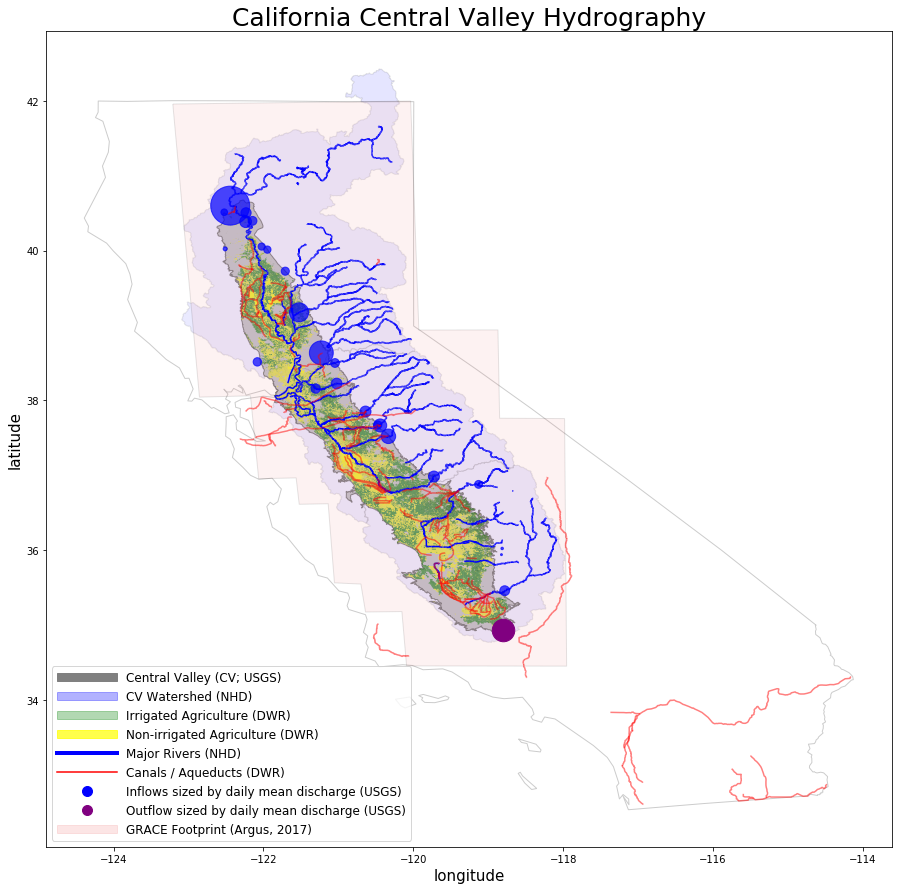

In [204]:
fig, ax = plt.subplots(figsize = (20, 15))

# Plot the huc4s
s.plot(ax = ax, color = 'blue', alpha = 0.1, edgecolor = "black")
sj.plot(ax = ax, color = 'blue', alpha = 0.1, edgecolor = "black")
t.plot(ax = ax, color = 'blue', alpha = 0.1,  edgecolor = "black")

# Rivers, CV, canals, CA, irrigated, non irrigated
rivers.plot(ax = ax, color = "blue", label = "major rivers")
cv.plot(ax = ax, color = "gray", edgecolor = "black", alpha = 0.5, )
canals.plot(ax = ax, color = "red", edgecolor = "none", alpha = 0.5)
swp.plot(ax = ax, color = "red", edgecolor = "none", alpha = 0.5,)
ca.plot(ax = ax, color = "white", edgecolor = "black", alpha = 0.2)
irrigated.plot(ax = ax, color = "green", alpha = 0.7)
non_irrigated.plot(ax = ax, color = "yellow", alpha = 0.7)
grace.plot(ax = ax, color = "lightcoral", alpha = 0.1, edgecolor = 'black')
inflow.plot(ax=ax, marker=".", alpha=0.7, c = "blue", markersize = inflow['mean']*0.7,  label = "USGS gauge Inflow sized by $Q_{daily}$ ")
outflow.plot(ax=ax, marker=".", alpha=1, c = "purple", markersize = outflow['mean'], label = "CA Aquedut Outflow sized by $Q_{daily}$ ")
# avg_stage.plot(ax = ax, markersize = avg_stage.storage*1000, color = "red", alpha = 0.7, edgecolor='black')
# wells.plot(ax = ax, markersize = 1, color = "gray", alpha = 0.7)


plt.ylabel('latitude', size = 15)
plt.xlabel('longitude', size = 15)

legend_elements = [Patch(facecolor='gray', edgecolor='gray',label='Central Valley (CV; USGS)'), 
                   Patch(facecolor='blue', alpha = 0.3, edgecolor='blue',label='CV Watershed (NHD)'),
                   
                   Patch(facecolor='green', alpha = 0.3, edgecolor='green',label='Irrigated Agriculture (DWR)'),
                   Patch(facecolor='yellow', alpha = 0.7, edgecolor='yellow',label='Non-irrigated Agriculture (DWR)'),
                   
                   Line2D([0], [0], color='b', lw=4, label='Major Rivers (NHD)'),
                   Line2D([0], [0], color='red', label = "Canals / Aqueducts (DWR)" ),
                   
#                    Line2D(range(1), range(1), color="red", marker='o',markersize=10, label = "Reservoirs sized by daily mean storage (CDEC)"),
                   Line2D([0], [0], color="blue", marker='o',markersize=10,linestyle = "none", label = "Inflows sized by daily mean discharge (USGS)"),
                   Line2D([0], [0], color="purple", marker='o',markersize=10, linestyle = "none", label = "Outflow sized by daily mean discharge (USGS)"),

                   Patch(facecolor='lightcoral', alpha = 0.2, edgecolor='lightcoral',label='GRACE Footprint (Argus, 2017)')
                  ]

plt.legend(loc = "lower left", handles = legend_elements, prop={'size':12},handlelength=5)

plt.title("California Central Valley Hydrography", size = 25)

plt.show()

In [187]:
cvwells = gp.sjoin(wells, cv, how = "inner", op = "intersects")

In [182]:
canals.drop('index_right', axis= 1, inplace = True)
ssjcanals = gp.sjoin(canals, hu4, how = "inner", op = "intersects")

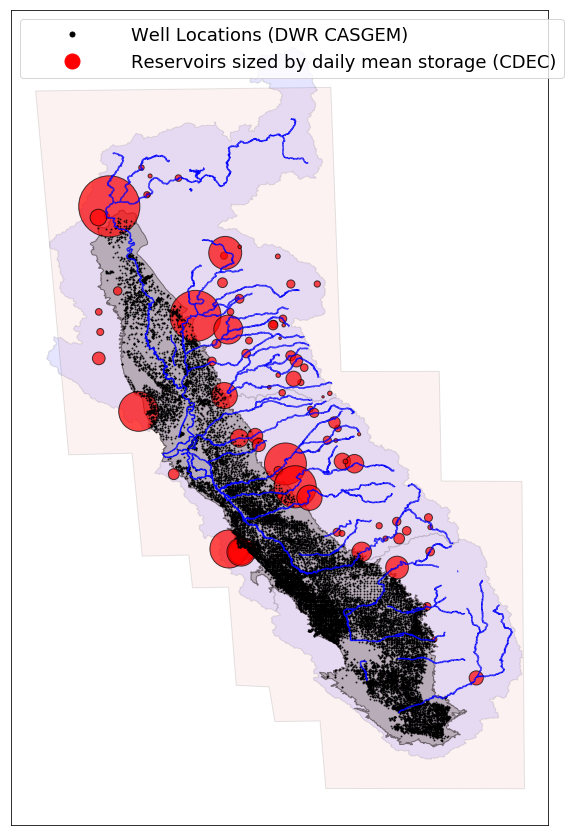

In [206]:
fig, ax = plt.subplots(figsize = (20, 15))

# Plot the huc4s
s.plot(ax = ax, color = 'blue', alpha = 0.1, edgecolor = "black")
sj.plot(ax = ax, color = 'blue', alpha = 0.1, edgecolor = "black")
t.plot(ax = ax, color = 'blue', alpha = 0.1,  edgecolor = "black")

# Rivers, CV, canals, CA, irrigated, non irrigated
rivers.plot(ax = ax, color = "blue", label = "major rivers")
cv.plot(ax = ax, color = "gray", edgecolor = "black", alpha = 0.5)
# ssjcanals.plot(ax = ax, color = "red", edgecolor = "none", alpha = 0.5)
# swp.plot(ax = ax, color = "red", edgecolor = "none", alpha = 0.5)
# irrigated.plot(ax = ax, color = "green", alpha = 0.7)
# non_irrigated.plot(ax = ax, color = "yellow", alpha = 0.7)
grace.plot(ax = ax, color = "lightcoral", alpha = 0.1, edgecolor = 'black')
# inflow.plot(ax=ax, marker=".", alpha=0.7, c = "blue", markersize = inflow['mean']*0.7,  label = "USGS gauge Inflow sized by $Q_{daily}$ ")
# outflow.plot(ax=ax, marker=".", alpha=1, c = "purple", markersize = outflow['mean'], label = "CA Aquedut Outflow sized by $Q_{daily}$ ")
avg_stage.plot(ax = ax, markersize = avg_stage.storage*1000, color = "red", alpha = 0.7, edgecolor='black')
cvwells.plot(ax = ax, markersize = 1, color = "black", alpha = 0.7)


# plt.ylabel('latitude', size = 15)
# plt.xlabel('longitude', size = 15)
plt.xticks([])
plt.yticks([])

legend_elements = [
#                    Line2D([0], [0], color='b', lw=4, label='Major Rivers (NHD)'),
#                    Line2D([0], [0], color='red', label = "Canals / Aqueducts (DWR)" ),
                   Line2D([0], [0], color="black", marker='.', linestyle = "none", markersize=10, label = "Well Locations (DWR CASGEM)"),
                   Line2D([0], [0], color="red", marker='.',linestyle = "none", markersize=30,  label = "Reservoirs sized by daily mean storage (CDEC)"),
#                    Line2D(range(1), range(1), color="blue", marker='o',markersize=10, label = "Inflows sized by daily mean discharge (USGS)"),
#                    Line2D(range(1), range(1), color="purple", marker='o',markersize=10, label = "Outflow sized by daily mean discharge (USGS)"),
#                    Patch(facecolor='gray', edgecolor='gray',label='Central Valley (CV; USGS)'), 
#                    Patch(facecolor='blue', alpha = 0.3, edgecolor='blue',label='CV Watershed (NHD)'),
#                    Patch(facecolor='green', alpha = 0.3, edgecolor='green',label='Irrigated Agriculture (DWR)'),
#                    Patch(facecolor='yellow', alpha = 0.7, edgecolor='yellow',label='Non-irrigated Agriculture (DWR)'),
#                    Patch(facecolor='lightcoral', alpha = 0.2, edgecolor='lightcoral',label='GRACE Footprint (Argus, 2017)')
                  ]

plt.legend(loc = "upper left", handles = legend_elements, prop={'size':18},handlelength=5)

# plt.title("California Hydrography", size = 25)
# plt.axis("off")
plt.show()